In [48]:
# Preamble and imports

# If you get CUDA errors, quit Jupyter, run these shell commands, and restart Jupyter
# export CUDA_HOME=/pkgs_local/cuda-9.0
# export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/pkgs_local/cuda-9.0/lib64

# Imports
import os
import argparse
import sys
import tensorflow as tf
import time
import numpy as np
import matplotlib.pyplot as plt

print('Imports ok.')

Imports ok.


In [49]:
# Set Number of Epochs and Batch Size
NUM_EPOCHS = 60
BATCH_SIZE = 50

# Train/test data is not in the Git repo because they are large files.
# Download and unzip "MNIST Basic" and "Rotated MNIST digits" from: http://www.iro.umontreal.ca/~lisa/twiki/bin/view.cgi/Public/MnistVariations

# Place in a folder called "data" or edit the paths below


# Data Sources

# === TRAIN ===

# Basic
B_TRAIN_DATA = "data/mnist_train.amat"
# Rotated
R_TRAIN_DATA = "data/mnist_all_rotation_normalized_float_train_valid.amat"


## === TEST ===

# Basic
B_TEST_DATA = "data/mnist_test.amat"
# Rotated
R_TEST_DATA = "data/mnist_all_rotation_normalized_float_test.amat"

print("OK.")

OK.


In [50]:
# Helper functions to read Montreal data

## CASEY NOTE: new function to read the .amat
PIXELS = 784
CLASSES = 10
def readAmat(filename):
    array = np.loadtxt(filename)
    # see https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.split.html#numpy-split
    data, labels = np.split(array, [PIXELS], axis=1)
    return data, labels

## CASEY NOTE: new function to get batches
## from https://stackoverflow.com/questions/49858574/how-to-implement-correctly-next-batch-in-custom-dataset-in-tensorflow
def next_batch(num, data, labels):
    '''
    Return a total of maximum `num` random samples and labels.
    NOTE: The last batch will be of size len(data) % num
    '''
    num_el = data.shape[0]
    while True: # or whatever condition you may have
        idx = np.arange(0 , num_el)
        np.random.shuffle(idx)
        current_idx = 0
        while current_idx < num_el:
            batch_idx = idx[current_idx:current_idx+num]
            current_idx += num
            data_shuffle = [data[ i,:] for i in batch_idx]
            labels_shuffle = [labels[ i] for i in batch_idx]
            yield np.asarray(data_shuffle), np.asarray(labels_shuffle)
            
print("OK.")

OK.


In [51]:
# Define layers.

# This net is based on instructions at https://www.tensorflow.org/versions/r1.0/get_started/mnist/pros (hmmm seems to no longer exist)

FLAGS = None

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)


def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)


def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')


def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

print("OK.")

OK.


In [52]:
## LOAD DATA (this takes a few seconds)

print("Loading train data...")
b_train_data, b_train_labels = readAmat(B_TRAIN_DATA)
r_train_data, r_train_labels = readAmat(R_TRAIN_DATA)
b_train_len = b_train_labels.shape[0]
r_train_len = r_train_labels.shape[0]

b_train_labels = b_train_labels.squeeze() # Resize from (50000, 1) to (50000,)
r_train_labels = r_train_labels.squeeze() # Resize from (50000, 1) to (50000,)
print("Train data loaded ({} basic, {} rotated)".format(b_train_len, r_train_len))

print("Loading test data (this takes a few seconds)...")
b_test_data, b_test_labels = readAmat(B_TEST_DATA)
r_test_data, r_test_labels = readAmat(R_TEST_DATA)
b_test_len = b_test_labels.shape[0]
r_test_len = r_test_labels.shape[0]

b_test_labels = b_test_labels.squeeze() # Resize from (50000, 1) to (50000,)
r_test_labels = r_test_labels.squeeze() # Resize from (50000, 1) to (50000,)
print("Test data loaded ({} basic, {} rotated)".format(b_test_len, r_test_len))

Loading train data...
Train data loaded (12000 basic, 12000 rotated)
Loading test data (this takes a few seconds)...
Test data loaded (50000 basic, 50000 rotated)


In [53]:
## Define model

# ---------------- MODEL DEF -------------------
x = tf.placeholder(tf.float32, [None, PIXELS])
y_ = tf.placeholder(tf.int64, [None])

W = tf.Variable(tf.zeros([PIXELS, CLASSES]))
b = tf.Variable(tf.zeros([CLASSES]))

# --- 1 --- define our first convolutional layer
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])
x_image = tf.reshape(x, [-1, 28, 28, 1])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)
# image is now 14x14

# --- 2 --- DEFINE 2nd convolutional layer
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2)+ b_conv2)
h_pool2 = max_pool_2x2(h_conv2)
# image is now 7x7

# --- 3 --- DENSELY CONNECTED LAYER
# fully connected, 1024 neurons

W_fc1 = weight_variable([7*7*64, 1024])
# input is 7x7 x 64 channels
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

# --- 4 --- DROPOUT
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# --- 5 --- READOUT LAYER: readout to our 10 values in the one-hot label

W_fc2 = weight_variable([1024, CLASSES])
b_fc2 = bias_variable([CLASSES])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2


cross_entropy = tf.reduce_mean(tf.losses.sparse_softmax_cross_entropy(labels=y_, logits=y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

# evaluating our model
correct_prediction = tf.equal(tf.argmax(y_conv, 1), y_)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

print('OK.')

OK.


In [54]:
# Run test accuracy calculation in batches to avoid OOM on 50k images

def calcTestAcc(sess, test_data, test_labels):

    print("Running batched test accuracy calculation...")

    # run test step many times!
    batch_size_test = BATCH_SIZE
    n_batches_test = int(len(test_labels) / batch_size_test)
    # print("n_batches_test: {}".format(n_batches_test))
    next_batch_generator = next_batch(num=batch_size_test, data=test_data, labels=test_labels)

    start = time.time()
    total = 0.0
    sum_count = 0
    for i in range(1):
        for j in range(n_batches_test):
            step_t = n_batches_test*i+j
            # batch is a 2-tuple of data, label: (batch_size, 784), (batch_size)
            batch_x, _batch_y = next(next_batch_generator) # this is the call to our load from the .amat
            batch_y = _batch_y.squeeze() # i.e. needs to be (50), not (50, 1)
            test_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob: 1.0})
            total += test_accuracy

#             if step_t%100 == 0:
#                 print("Epoch {} | Step {}, step test accuracy {:.2f}%".format(i, step_t, test_accuracy * 100.0))

    end = time.time()

    # print("Test time: {} sec".format(end - start))
    mean_test_acc = total / n_batches_test

    # -----------------------

    # print("\nMean test accuracy of all batches: {:.2f}%".format(mean_test_acc * 100.0))
    return mean_test_acc

sess = None
print("OK.")

OK.


In [55]:
# TODO: WRITE LOOP TO ESTABLISH BASELINE

# 158 sec, 10 epochs, 97% test acc on b vs b
# 88% on r vs r

results = [None] * 2
results[0] = [None] * 2
results[1] = [None] * 2

results[0][0] = []
results[0][1] = []
results[1][0] = []
results[1][1] = []

step_index = []

rb = 0

if sess is not None:
    # If replaying this cell, clear sess
    sess.close()

for train_data, train_labels in [(b_train_data, b_train_labels), (r_train_data, r_train_labels)]:
    print("Starting rb={}".format(rb))
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    # initialize all variables
    tf.global_variables_initializer().run()
    
    # run training step many times!
    batch_size = BATCH_SIZE
    n_batches = int(len(train_labels) / batch_size)
    print("n_batches: {}".format(n_batches))
    next_batch_generator = next_batch(num=batch_size, data=train_data, labels=train_labels)

    start = time.time()
    for i in range(NUM_EPOCHS):
        for j in range(n_batches):
            step = n_batches*i+j
            # batch is a 2-tuple of data, label: (batch_size, 784), (batch_size)
            batch_x, batch_y = next(next_batch_generator) # this is the call to our load from the .amat
            # batch_y = _batch_y.squeeze() # i.e. needs to be (50), not (50, 1)

            if step%100 == 0:
                train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob: 1.0})
                print("Epoch {} | Step {}, training accuracy {:.2f}%".format(i, step, train_accuracy*100.0))
                
                b_acc = calcTestAcc(sess, b_test_data, b_test_labels)
                results[rb][0].append(b_acc)
                print("Appending {} to trained_on_{}'s test_on_b".format(b_acc, rb))
                
                r_acc = calcTestAcc(sess, r_test_data, r_test_labels)
                results[rb][1].append(r_acc)
                print("Appending {} to trained_on_{}'s test_on_r".format(r_acc, rb))
                
                if (rb == 0):
                    step_index.append(step)
                    
            train_step.run(feed_dict={x:batch_x, y_:batch_y, keep_prob: 0.5})

    end = time.time()
    print("Training time: {} sec".format(end - start))
    print("-"*10)
    rb += 1 # Move onto next train set
    sess.close()
    print("TF session closed.")

Starting rb=0
n_batches: 240
Epoch 0 | Step 0, training accuracy 10.00%
Running batched test accuracy calculation...
Appending 0.09941999929770827 to trained_on_0's test_on_b
Running batched test accuracy calculation...
Appending 0.09759999937191606 to trained_on_0's test_on_r
Epoch 0 | Step 100, training accuracy 86.00%
Running batched test accuracy calculation...
Appending 0.8418399942517281 to trained_on_0's test_on_b
Running batched test accuracy calculation...
Appending 0.23893999949842692 to trained_on_0's test_on_r
Epoch 0 | Step 200, training accuracy 86.00%
Running batched test accuracy calculation...
Appending 0.8955999959111214 to trained_on_0's test_on_b
Running batched test accuracy calculation...
Appending 0.2506999995559454 to trained_on_0's test_on_r
Epoch 1 | Step 300, training accuracy 100.00%
Running batched test accuracy calculation...
Appending 0.9205599961876869 to trained_on_0's test_on_b
Running batched test accuracy calculation...
Appending 0.2580799998566508 t

Appending 0.29342000018805264 to trained_on_0's test_on_r
Epoch 13 | Step 3300, training accuracy 100.00%
Running batched test accuracy calculation...
Appending 0.9769600027799606 to trained_on_0's test_on_b
Running batched test accuracy calculation...
Appending 0.2816000001206994 to trained_on_0's test_on_r
Epoch 14 | Step 3400, training accuracy 100.00%
Running batched test accuracy calculation...
Appending 0.9770200023055077 to trained_on_0's test_on_b
Running batched test accuracy calculation...
Appending 0.29324000081419943 to trained_on_0's test_on_r
Epoch 14 | Step 3500, training accuracy 98.00%
Running batched test accuracy calculation...
Appending 0.9777200026512146 to trained_on_0's test_on_b
Running batched test accuracy calculation...
Appending 0.28848000027984383 to trained_on_0's test_on_r
Epoch 15 | Step 3600, training accuracy 100.00%
Running batched test accuracy calculation...
Appending 0.9783800030350686 to trained_on_0's test_on_b
Running batched test accuracy calcu

Appending 0.9796200031042099 to trained_on_0's test_on_b
Running batched test accuracy calculation...
Appending 0.2831200001984835 to trained_on_0's test_on_r
Epoch 27 | Step 6600, training accuracy 100.00%
Running batched test accuracy calculation...
Appending 0.9803400028944016 to trained_on_0's test_on_b
Running batched test accuracy calculation...
Appending 0.2946800004169345 to trained_on_0's test_on_r
Epoch 27 | Step 6700, training accuracy 100.00%
Running batched test accuracy calculation...
Appending 0.9820600037574768 to trained_on_0's test_on_b
Running batched test accuracy calculation...
Appending 0.28750000055879354 to trained_on_0's test_on_r
Epoch 28 | Step 6800, training accuracy 100.00%
Running batched test accuracy calculation...
Appending 0.9804600036740303 to trained_on_0's test_on_b
Running batched test accuracy calculation...
Appending 0.2947400009855628 to trained_on_0's test_on_r
Epoch 28 | Step 6900, training accuracy 100.00%
Running batched test accuracy calcul

Epoch 40 | Step 9800, training accuracy 100.00%
Running batched test accuracy calculation...
Appending 0.982760003566742 to trained_on_0's test_on_b
Running batched test accuracy calculation...
Appending 0.29652000023424624 to trained_on_0's test_on_r
Epoch 41 | Step 9900, training accuracy 100.00%
Running batched test accuracy calculation...
Appending 0.9830600033998489 to trained_on_0's test_on_b
Running batched test accuracy calculation...
Appending 0.2908000005185604 to trained_on_0's test_on_r
Epoch 41 | Step 10000, training accuracy 100.00%
Running batched test accuracy calculation...
Appending 0.9827600031495094 to trained_on_0's test_on_b
Running batched test accuracy calculation...
Appending 0.29708000088483094 to trained_on_0's test_on_r
Epoch 42 | Step 10100, training accuracy 100.00%
Running batched test accuracy calculation...
Appending 0.9820800038576126 to trained_on_0's test_on_b
Running batched test accuracy calculation...
Appending 0.29373999996483324 to trained_on_0'

Appending 0.9837200040221215 to trained_on_0's test_on_b
Running batched test accuracy calculation...
Appending 0.2926999999433756 to trained_on_0's test_on_r
Epoch 54 | Step 13100, training accuracy 100.00%
Running batched test accuracy calculation...
Appending 0.9832800033092499 to trained_on_0's test_on_b
Running batched test accuracy calculation...
Appending 0.2948400008007884 to trained_on_0's test_on_r
Epoch 55 | Step 13200, training accuracy 100.00%
Running batched test accuracy calculation...
Appending 0.9836200039982795 to trained_on_0's test_on_b
Running batched test accuracy calculation...
Appending 0.29226000056415796 to trained_on_0's test_on_r
Epoch 55 | Step 13300, training accuracy 100.00%
Running batched test accuracy calculation...
Appending 0.9840600038170815 to trained_on_0's test_on_b
Running batched test accuracy calculation...
Appending 0.2974600006863475 to trained_on_0's test_on_r
Epoch 55 | Step 13400, training accuracy 100.00%
Running batched test accuracy ca

Appending 0.8700399948358536 to trained_on_1's test_on_r
Epoch 7 | Step 1900, training accuracy 90.00%
Running batched test accuracy calculation...
Appending 0.5713600021898746 to trained_on_1's test_on_b
Running batched test accuracy calculation...
Appending 0.8732999950647354 to trained_on_1's test_on_r
Epoch 8 | Step 2000, training accuracy 84.00%
Running batched test accuracy calculation...
Appending 0.5505400010645389 to trained_on_1's test_on_b
Running batched test accuracy calculation...
Appending 0.8791599947214127 to trained_on_1's test_on_r
Epoch 8 | Step 2100, training accuracy 96.00%
Running batched test accuracy calculation...
Appending 0.5695600020587445 to trained_on_1's test_on_b
Running batched test accuracy calculation...
Appending 0.8811999958753586 to trained_on_1's test_on_r
Epoch 9 | Step 2200, training accuracy 94.00%
Running batched test accuracy calculation...
Appending 0.5662800023555755 to trained_on_1's test_on_b
Running batched test accuracy calculation...


Appending 0.9234999967217445 to trained_on_1's test_on_r
Epoch 21 | Step 5200, training accuracy 96.00%
Running batched test accuracy calculation...
Appending 0.533039999961853 to trained_on_1's test_on_b
Running batched test accuracy calculation...
Appending 0.9220599970817566 to trained_on_1's test_on_r
Epoch 22 | Step 5300, training accuracy 98.00%
Running batched test accuracy calculation...
Appending 0.517159999936819 to trained_on_1's test_on_b
Running batched test accuracy calculation...
Appending 0.9234599962830543 to trained_on_1's test_on_r
Epoch 22 | Step 5400, training accuracy 96.00%
Running batched test accuracy calculation...
Appending 0.5396200003921986 to trained_on_1's test_on_b
Running batched test accuracy calculation...
Appending 0.9242999970316886 to trained_on_1's test_on_r
Epoch 22 | Step 5500, training accuracy 98.00%
Running batched test accuracy calculation...
Appending 0.5341000007987022 to trained_on_1's test_on_b
Running batched test accuracy calculation..

Appending 0.5288200008869172 to trained_on_1's test_on_b
Running batched test accuracy calculation...
Appending 0.9333999970555306 to trained_on_1's test_on_r
Epoch 35 | Step 8500, training accuracy 100.00%
Running batched test accuracy calculation...
Appending 0.514919999808073 to trained_on_1's test_on_b
Running batched test accuracy calculation...
Appending 0.9350399963259697 to trained_on_1's test_on_r
Epoch 35 | Step 8600, training accuracy 100.00%
Running batched test accuracy calculation...
Appending 0.5077599994242191 to trained_on_1's test_on_b
Running batched test accuracy calculation...
Appending 0.9325599979758262 to trained_on_1's test_on_r
Epoch 36 | Step 8700, training accuracy 100.00%
Running batched test accuracy calculation...
Appending 0.516359999626875 to trained_on_1's test_on_b
Running batched test accuracy calculation...
Appending 0.9360599974989892 to trained_on_1's test_on_r
Epoch 36 | Step 8800, training accuracy 100.00%
Running batched test accuracy calculati

Epoch 48 | Step 11700, training accuracy 100.00%
Running batched test accuracy calculation...
Appending 0.5209400000274181 to trained_on_1's test_on_b
Running batched test accuracy calculation...
Appending 0.9408399975895881 to trained_on_1's test_on_r
Epoch 49 | Step 11800, training accuracy 100.00%
Running batched test accuracy calculation...
Appending 0.5217399995923042 to trained_on_1's test_on_b
Running batched test accuracy calculation...
Appending 0.9394799979925156 to trained_on_1's test_on_r
Epoch 49 | Step 11900, training accuracy 100.00%
Running batched test accuracy calculation...
Appending 0.5198600006997586 to trained_on_1's test_on_b
Running batched test accuracy calculation...
Appending 0.9396999984979629 to trained_on_1's test_on_r
Epoch 50 | Step 12000, training accuracy 100.00%
Running batched test accuracy calculation...
Appending 0.5140200000107288 to trained_on_1's test_on_b
Running batched test accuracy calculation...
Appending 0.9394199977517128 to trained_on_1'

In [56]:
# Call this for cleanup at the end
sess.close()
print("TF session closed.")

TF session closed.


0.98,0.28,0.53,0.94
14300


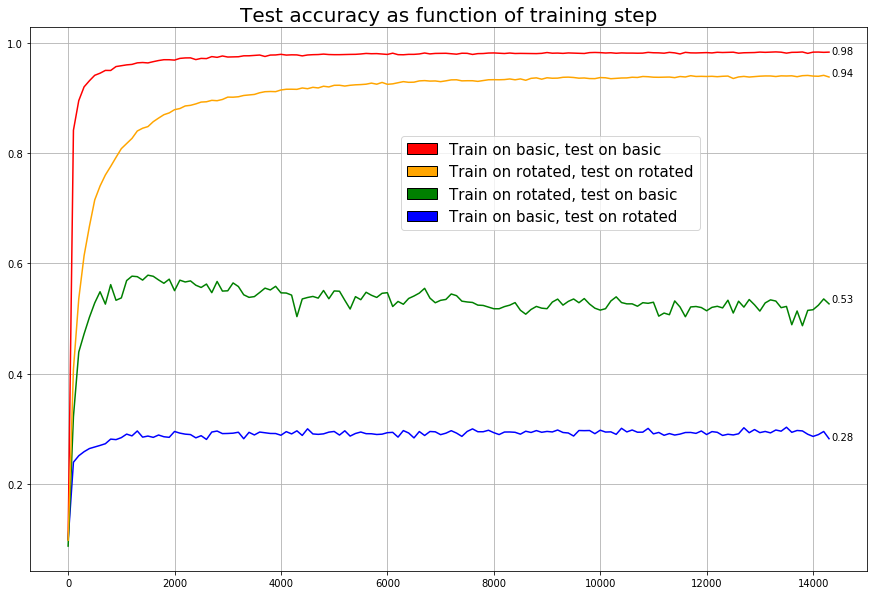

In [85]:
# Plot the accuracies

from matplotlib.patches import Rectangle

tr_b_test_b = results[0][0]
tr_b_test_r = results[0][1]
tr_r_test_b = results[1][0]
tr_r_test_r = results[1][1]

a = [ '%.2f' % elem for elem in tr_b_test_b ]
b = [ '%.2f' % elem for elem in tr_b_test_r ]
c = [ '%.2f' % elem for elem in tr_r_test_b ]
d = [ '%.2f' % elem for elem in tr_r_test_r ]

a_f = a[-1]
b_f = b[-1]
c_f = c[-1]
d_f = d[-1]

print("{},{},{},{}".format(a_f, b_f, c_f, d_f))

print(step_index[-1])
last_step = step_index[-1]

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,10))

plt.plot(step_index, results[0][0], color="red")
plt.plot(step_index, results[0][1], color="blue")
plt.plot(step_index, results[1][0], color="green")
plt.plot(step_index, results[1][1], color="orange")

handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in ["red","orange","green","blue"]]
labels = ["Train on basic, test on basic",
          "Train on rotated, test on rotated",
          "Train on rotated, test on basic",
          "Train on basic, test on rotated"
          ]
params = {'legend.fontsize': 15,
          'legend.handlelength': 2}
plt.rcParams.update(params)


plt.legend(handles, labels, bbox_to_anchor=(0.8, 0.8), loc=1, borderaxespad=0.)
plt.grid()
plt.title("Test accuracy as function of training step", fontsize=20)

gap = 50
plt.text(last_step+gap, float(a_f), str(a_f))
plt.text(last_step+gap, float(b_f), str(b_f))
plt.text(last_step+gap, float(c_f), str(c_f))
plt.text(last_step+gap, float(d_f), str(d_f))




plt.show()